In [1]:
from tqdm import tqdm
import psycopg2
import pandas as pd
from datetime import datetime, timedelta
DB_HOST = 'localhost'
DB_NAME = 'us'
DB_USER = 'postgres'
DB_PASS = 'buddyrich134'
def get_db_connection():
    conn = psycopg2.connect(host=DB_HOST, dbname=DB_NAME, user=DB_USER, password=DB_PASS)
    return conn


conn = get_db_connection()
cursor = conn.cursor()
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

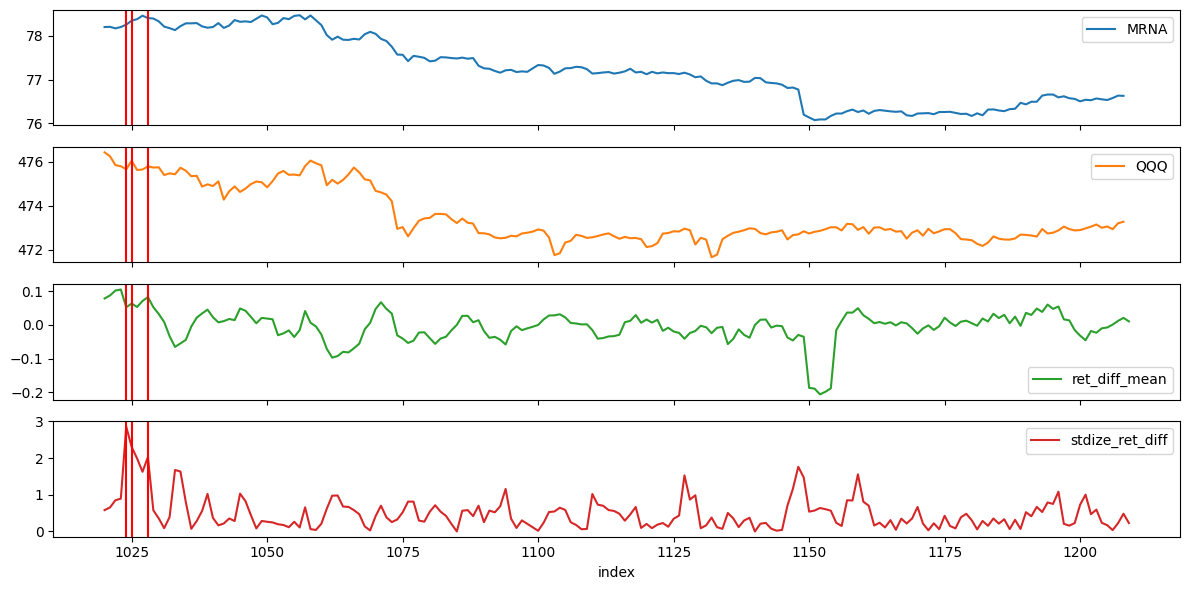

code,MRNA,QQQ,ret_diff,ret_diff_std,ret_diff_mean,stdize_ret_diff,index,MRNA_lag60,TWII_lag60,lag10,direction,target_60mins,da
index,,,,,,,,,,,,,
202,78.535,477.300,-0.000488,0.020321,-0.070304,3.435628,202,78.725,477.590,78.595,1,0.002,2024-08-27 13:34:00
243,78.845,477.325,0.000254,0.015036,0.044002,2.909610,243,78.730,477.165,78.795,-1,0.001,2024-08-27 14:15:00
244,78.820,477.185,0.000265,0.016273,0.042910,2.620610,244,78.680,477.065,78.790,-1,0.002,2024-08-27 14:16:00
570,78.740,471.335,-0.000211,0.012971,-0.026831,2.052217,570,78.460,468.890,78.580,-1,0.004,2024-08-28 13:40:00
900,78.220,472.760,0.000211,0.032409,0.068345,2.102355,900,77.820,470.560,78.160,-1,0.005,2024-08-29 14:33:00
969,77.905,471.570,-0.000226,0.010689,-0.023597,2.186467,969,78.030,475.075,77.700,-1,0.002,2024-08-29 15:42:00
1024,78.260,475.665,0.000489,0.018213,0.052561,2.859028,1024,78.385,475.415,78.410,1,0.002,2024-08-30 10:07:00
1025,78.350,476.050,0.000998,0.027058,0.063337,2.303900,1025,78.460,475.425,78.400,1,0.001,2024-08-30 10:08:00
1028,78.410,475.800,0.000979,0.040140,0.082480,2.030422,1028,78.470,476.060,78.180,-1,0.001,2024-08-30 10:11:00


In [24]:
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")
code = 'MRNA'
rolling = 5
cursor.execute(f"SELECT da, code, cl from public.stock_price where code in ('{code}', 'QQQ')")
conn.commit()
res = cursor.fetchall()
df = pd.DataFrame(res)
df.columns = ['da','code', 'cl']
pivoted = df.pivot(columns='code', values='cl', index='da')
pivoted.ffill()
ret = pivoted.pct_change()
ret['ret_diff'] = ret[code] - ret['QQQ']
ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std() * 100
ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean() * 100
ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])/ret['ret_diff_std'])
ret[code] = pivoted[code].shift(-1)
ret['QQQ'] = pivoted['QQQ'].shift(-1)

ret['index'] = [i for i in range(len(ret))]

# check raise
ret[f'{code}_lag60'] = ret[code].shift(-30)
ret[f'TWII_lag60'] = ret["QQQ"].shift(-30)
ret['lag10'] = ret[code].shift(-4)

ret['direction'] = ret.apply(lambda x: -1 if x[code] - x['lag10'] > 0 else 1, axis=1)
ret['target_60mins'] = abs(np.round((ret[f'{code}_lag60'] - ret[code])/ret[code], 3))
# ret['filter_1'] = ret.apply(lambda x: 1 if abs(x['change_stock'] - x['change_twii']) < abs(x['change_stock']) else 0, axis=1)
# ret['filter_2'] = ret.apply(lambda x: 1 if abs(x['change_stock']) < abs(x['change_twii']) else 1, axis=1)
            
# specific print
ret['da'] = pivoted.index
ret.set_index('index', inplace=True, drop=False)
# start = -54 # -268
start = 1020
end = len(ret)
bm = 2
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 6), sharex=True)
ret.iloc[start:end, [0, 1, 4, 5]].plot(ax=axes, subplots=True, legend=True)
for index, row in ret.iloc[start:end, :][ret['stdize_ret_diff'] >= bm].iterrows():  
    for ax in axes:
        ax.axvline(row['index'], color='red')
plt.tight_layout()
plt.show()

# check to long or short
ret[ret['stdize_ret_diff'] >= bm]